# EECS 491- Assignment4

The aim of this assignmet is to fully understand how to use EM algorithm to adapt the Gaussian mixture model and cluster data. There will be four Exericses. Exercise 1 and 2 will cluster data from 'faithful.txt' and exercise 3 and 4 will cluster data from 'mnist.pkl.gz'.

### Exercise 1

In this part, we will use EM algorithm to adapt the Gaussian mixture model. First, let me show the process of EM algorithm.  
EM algorithm involves two steps:  
1) E-step:
For hte case of Guaasian mixture model:  
Compute $$p_{n,k} = p(c_k \mid x^{(n)},\theta_{1:k}) $$  
Let $$p_k = \sum_n p_{n,k}$$

2) M-step:  
Compute new mean, covariance, and class prior for each class:  
mean: $$\mu_k =\sum_n p_{n,k}x^{(n)}/p_k$$  
covariance: $$\sum_n p_{n,k}(x^{(n)}- \mu_k)(x^{(n)}- \mu_k)^T / p_k$$  
class prior: $$p_k$$



The following part is using the EM algorithm to adapt the means of a 2D Gaussian mixture model with fixed covariance matrices:

In [56]:
import csv, copy, gzip, pickle

import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import chi2

%matplotlib inline

In [103]:
with open('data/faithful.txt', 'rt') as csvfile:
    dataReader = csv.reader(csvfile, delimiter=' ')
    # initialize an empty array
    data = []
    for row in dataReader:
        data.append(np.array(row).astype(np.float))
    # convert data into a numpy array
    data = np.asarray(data)

In [104]:
data.shape

(272, 2)

Set two Guassian mixture model here:

In [59]:
ngmm = 2

In [60]:
mu = np.asarray([[2, 70], 
                 [4, 80]]
               ).astype('float')

sigma = np.asarray([[[1, 0], 
                     [0, 3]], 
                    [[0.5, 0.2], 
                     [0.2, 0.6]]]
                  ).astype('float')

Make sure the covariance matrices are legal:

In [61]:
def covmatIsLegal(sigma):
    for covmat in sigma:
        if not(np.allclose(covmat, covmat.T)) or np.any(np.linalg.eigvals(covmat) <= 0):
            return False
    return True

print("Convariance Matrices are Legal? : %r" % covmatIsLegal(sigma))

Convariance Matrices are Legal? : True


In [62]:
gmm = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

In [2]:
def plotGaussianModel2D(mu, sigma, pltopt='k'):
    if sigma.any():
        # calculate ellipse constants
        c = chi2.ppf(0.9, 2) # use confidence interval 0.9
        # get eigen vector and eigen values
        eigenValue, eigenVector = np.linalg.eig(sigma)
        # calculate points on ellipse
        t = np.linspace(0, 2*np.pi, 100) # draw 100 points
        u = [np.cos(t), np.sin(t)]
        w = c * eigenVector.dot(np.diag(np.sqrt(eigenValue)).dot(u))
        z = w.T + mu
    else:
        z = mu
    # plot ellipse by connecting sample points on curve
    plt.plot(z[:,0], z[:,1], pltopt)
    
def colorPicker(index):
    colors = 'rgbcmyk'
    return colors[np.remainder(index, len(colors))]

def gmmplot(data, gmm):
    # plot data points
    plt.scatter(data[:, 0], data[:, 1], s=4)
    #plt.scatter(dataSet[0].tolist),dataSet[1].tolist()) 
    
    # plot Gaussian model
    color = 'rgb'
    for index, model in enumerate(gmm):
        plotGaussianModel2D(model['mean'], model['covariance'], colorPicker(index))

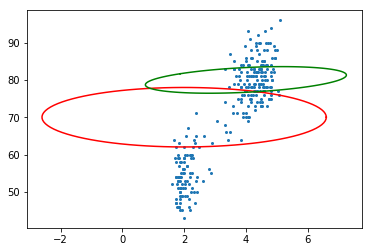

In [65]:
gmmplot(data, gmm)

EA algorithm coding:

In [86]:
import math 
from scipy.stats import multivariate_normal


def expectation(data, gmmcp):
    N = data.shape[0]
    K = len(gmmcp)
    
    posterior = np.zeros((N,K))
    #cal the multivariate gaussian distributions and likehood x prior
    for k in range(K):
        posterior[:, k] = gmmcp[k]['prior'] * multivariate_normal(mean = gmmcp[k]['mean'], cov = gmmcp[k]['covariance']).pdf(data)
       
    #cal (likehood x prior) / sum(likehood x prior)
    for i in range(N):
        if np.sum(posterior[i,:]) == 0:
            continue
        posterior[i,:] = posterior[i, :]/np.sum(posterior[i,:])
        
    return posterior

def maximizationmean(posterior,data, gmmcp):
    
    N,D = data.shape  
    K = len(gmmcp) 
    mu = np.zeros((K,D))
    cov = []
    prior = np.zeros(K)

    for k in range(K):
        Nk = np.sum(posterior[:,k])
        if Nk == 0:
            mu[k] = gmmcp[k]['mean']
            cov.append(gmmcp[k]['covariance'])
            prior[i] = gmmcp[k]['prior']
            continue

        for d in range(D):
            mu[k,d] = np.sum(posterior[:,k] * data[:,d]) / Nk


        covi = np.mat(np.zeros((D,D)))
                      
        for i in range(N):
            covi += posterior[i,k] * np.mat(data[i] - mu[k]).T * np.mat(data[i] - mu[k])/ Nk

        cov.append(covi)

        prior[k] = Nk/N

    cov = np.array(cov)
    
    gmmcp = [{'mean': mu[k], 'covariance': sigma[k], 'prior': prior[k]} for k in range(K)]
    return gmmcp


def maximization(posterior,data, gmmcp):
    
    N,D = data.shape  
    K = len(gmmcp) 
    mu = np.zeros((K,D))
    cov = []
    prior = np.zeros(K)

    for k in range(K):
        Nk = np.sum(posterior[:,k])
        if Nk == 0:
            mu[k] = gmmcp[k]['mean']
            cov.append(gmmcp[k]['covariance'])
            prior[i] = gmmcp[k]['prior']
            continue

        for d in range(D):
            mu[k,d] = np.sum(posterior[:,k] * data[:,d]) / Nk


        covi = np.mat(np.zeros((D,D)))
                      
        for i in range(N):
            covi += posterior[i,k] * np.mat(data[i] - mu[k]).T * np.mat(data[i] - mu[k])/ Nk

        cov.append(covi)

        prior[k] = Nk/N

    cov = np.array(cov)
    

    gmmcp = [{'mean': mu[k], 'covariance': cov[k], 'prior': prior[k]} for k in range(K)]
    return gmmcp

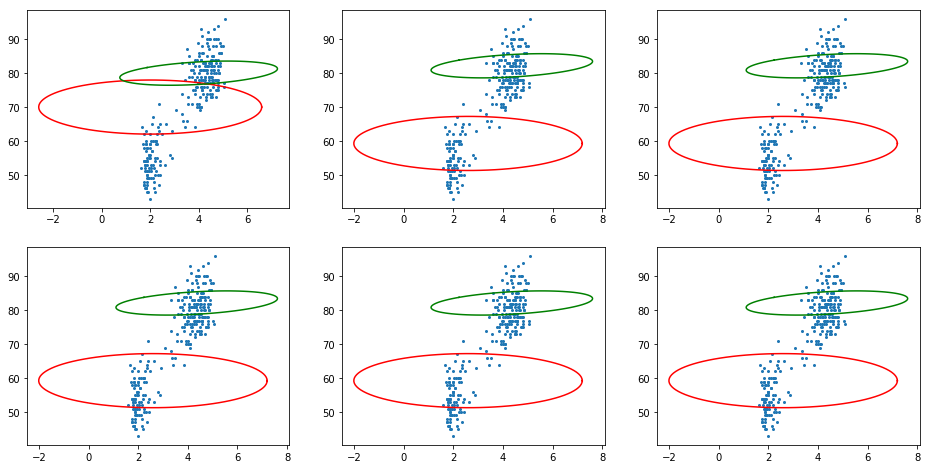

In [87]:
gmmcp = copy.deepcopy(gmm)

plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximizationmean(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

### Exercise 2

This part is similar to Exericse 1. But the the covariance matrices here are not fixed. We still use the coding above:

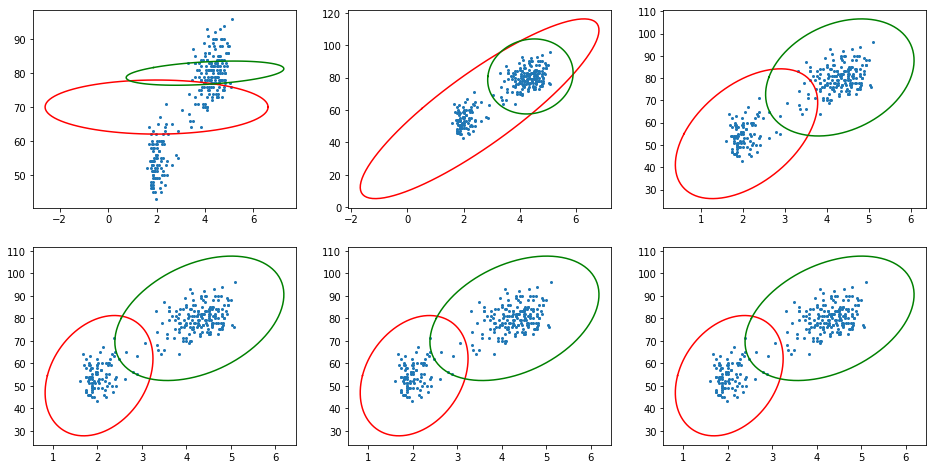

In [88]:
gmmcp = copy.deepcopy(gmm)

plt.figure(figsize=(16, 8))
# improve model with EM-Algorithm
for i in range(5):
    # plot current status
    plt.subplot(231 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(236)
gmmplot(data,gmmcp)

### Exercise 3

In this part the first thing we need to use PCA function to compute the principal components (PCs) of the MNIST dataset.Since we can't directly see a high dimensional data distribution, so we need PCA to reduce dimension to 2D.

Import Data and display picture:

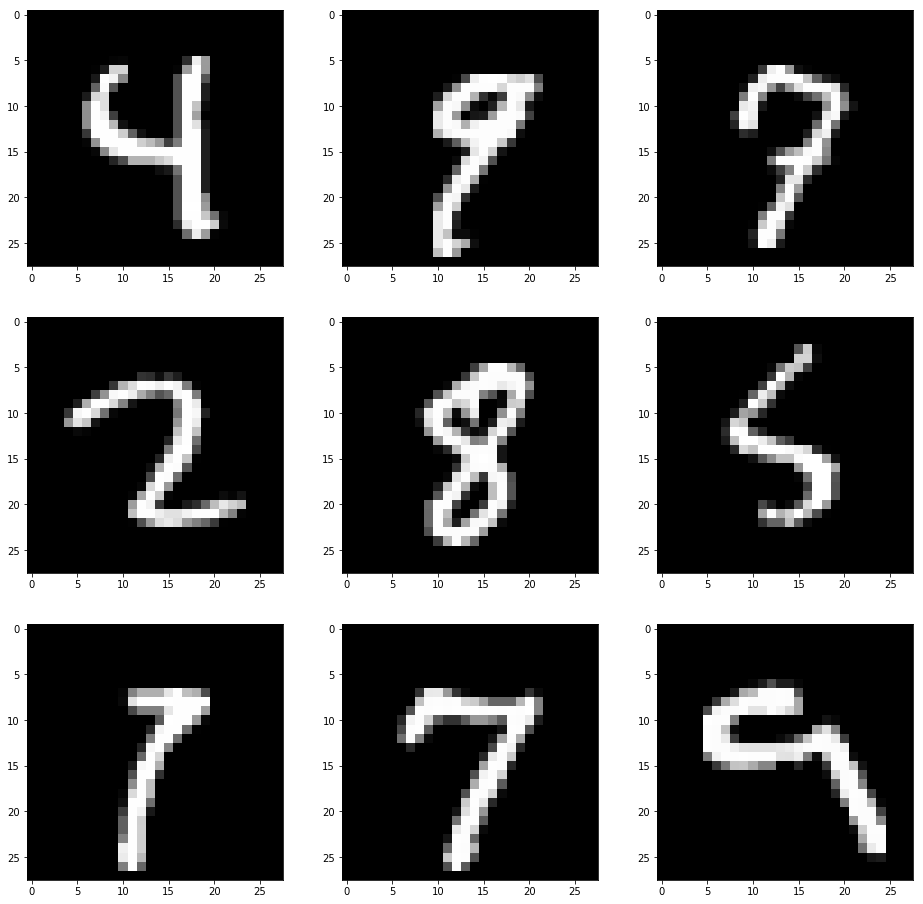

In [90]:
with gzip.open('data/mnist.pkl.gz', 'rb') as f:
    f = pickle._Unpickler(f)
    f.encoding = 'latin1'
    trainSet, validSet, testSet = f.load()
    mnistData = np.concatenate((trainSet[0], validSet[0], testSet[0]), axis=0)
    

def showImageSamples(imageset, n, shape=[28,28], col=3, width=16, dispopt='gray', random=True):
    row    = np.ceil(n / col)
    height = np.around(row * (width / col))
    plt.figure(figsize=(width, height))
    subplotIndex = 100 * row + 10 * col + 1
    for i in range(n):
        if random:
            img = imageset[np.random.randint(len(imageset), size=1)]
        else:
            img = imageset[i]
        plt.subplot(subplotIndex + i)
        plt.imshow(img.reshape(shape), cmap=dispopt)

        
showImageSamples(mnistData, 9)


PCA function:  
Reduce to 2D

In [106]:
mnistData.shape
T = mnistData - mnistData.mean(axis=0)

T.shape
C = np.cov(mnistData.T)
w,v = np.linalg.eig(C)
v_ = np.mat(v[:,0:2])

y = T * v_
print(y)

[[ 0.47755961 -1.23528843]
 [ 3.94724222 -1.13267038]
 [-0.23045291  1.53788064]
 ..., 
 [-1.06057424  2.30499415]
 [-1.21181569 -0.45596543]
 [ 4.13618019 -0.3257521 ]]


Reduce to 10D

In [110]:
v_2 = np.mat(v[:,0:10])

y2 = T * v_2
print(y2)

[[ 0.47755961 -1.23528843 -0.19973372 ..., -0.73759386 -1.4015583
  -0.79509768]
 [ 3.94724222 -1.13267038  2.25047165 ...,  0.3993402   0.13588365
  -0.59087905]
 [-0.23045291  1.53788064 -0.63280541 ..., -1.46206792 -0.30664547
   0.75280335]
 ..., 
 [-1.06057424  2.30499415  1.33347214 ...,  1.34662126 -0.20385807
   3.13879528]
 [-1.21181569 -0.45596543  2.48328123 ..., -0.56576758  1.11335297
   0.80102978]
 [ 4.13618019 -0.3257521   2.85680539 ...,  1.64614892  0.55180654
  -0.26248452]]


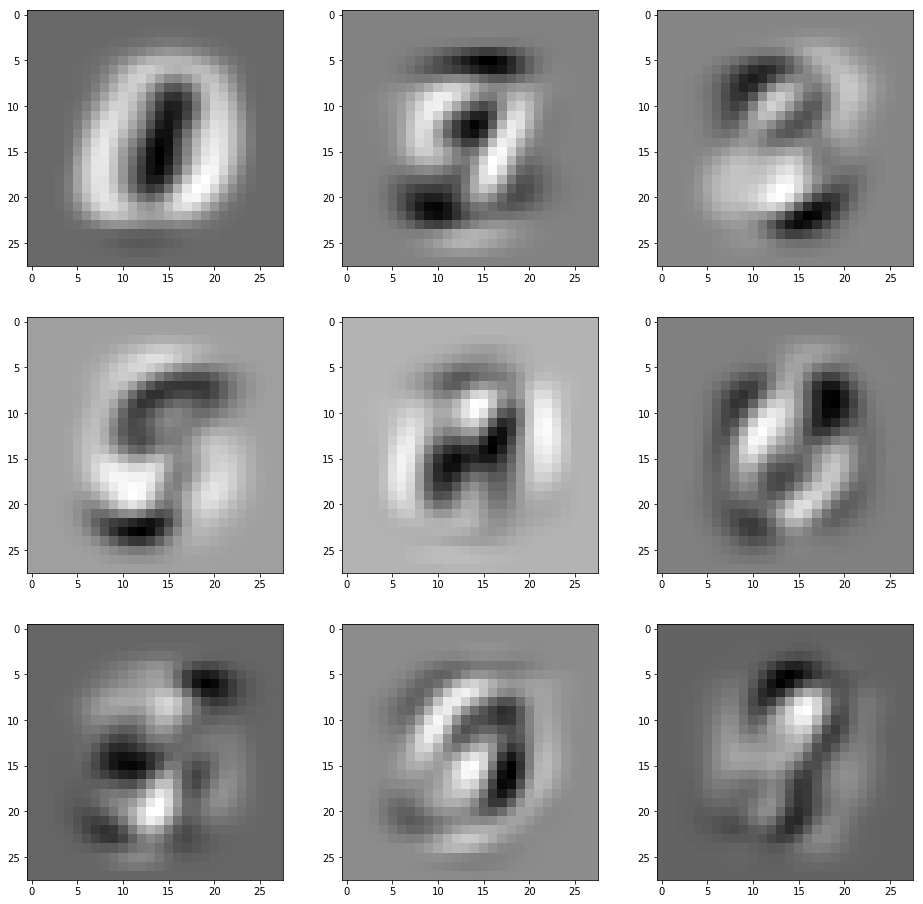

In [15]:
showImageSamples(v.T, 9, random=False)


### Exercise 4

In exercise 1&2， 2 Guassian mixture models are created by ourselves. In this part, we will create the model randomly and apply these model on data we just handled.

In [91]:
def randinitMean(n, drange):
    mu = []
    for m in range(n):
        mu.append([np.random.uniform(drange[i]['MIN'], drange[i]['MAX']) for i in range(len(drange))])
    # return inf form of numpy.ndarray
    return np.asarray(mu)

In [92]:
def randinitCovariance(n):
    sigma = []
    for m in range(n):
        # randomly pick a direction
        angle = np.random.uniform(0, 2 * np.pi)
        # create eigen vector with the direction and direction orthogonal to it
        eigenVector = np.asarray([[np.cos(angle), np.sin(angle)],
                                  [np.cos(angle + np.pi/2), np.sin(angle + np.pi/2)]])
        # randomly generate eigen values
        eigenValue = abs(np.random.normal(size=2))
        # compose covariance matrix
        sigma.append(eigenVector.T.dot(np.diag(eigenValue).dot(eigenVector)))
    # return in form of numpy.ndarray
    return np.asarray(sigma)

In [100]:
ndata = 1000
# randomly pick a subset of data
data2 = y[np.random.randint(len(y), size=ndata)]
data2 = np.asarray(data)
data2.shape

(1000, 2)

After setting up random Guassian matirx model function, apply these guassian with the data and display.

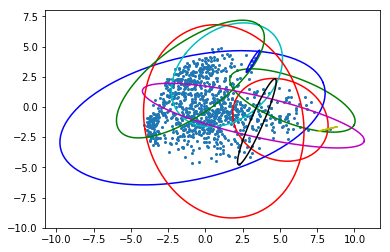

In [101]:
ngmm = 10

# get information of range on each dimension
dataRange = []
for i in range(data.shape[1]):
    dataRange.append({'MIN': min(data[:,i]), 'MAX': max(data[:,i])})
    
# randomly initialize Gaussian mixture model
mu    = randinitMean(ngmm, dataRange)
sigma = randinitCovariance(ngmm)
gmm   = [{'mean': mu[m], 'covariance': sigma[m], 'prior': 1.0/ngmm} for m in range(ngmm)]

# show initial state
gmmplot(data2, gmmcp)

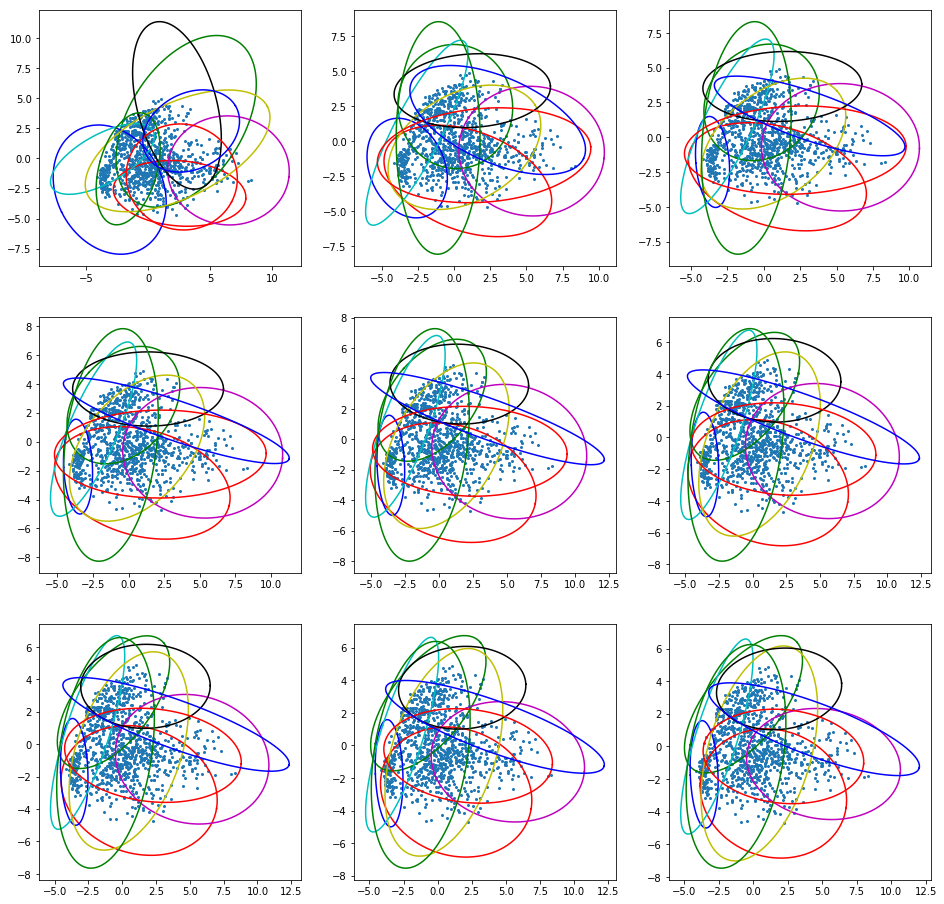

In [102]:
gmmcp = copy.deepcopy(gmm)

# create figure
plt.figure(figsize=(16, 16))
# improve model with EM-Algorithm
for i in range(8):
    # plot current status
    plt.subplot(331 + i)
    gmmplot(data, gmmcp)
    # excute EM-Algorithm
    for j in range(5):
        posterior = expectation(data, gmmcp)
        gmmcp = maximization(posterior, data, gmmcp)
# plot final status
plt.subplot(339)
gmmplot(data2,gmmcp)

### Further work

According to the reuslt above, we can find that when clustering high dimenison data and reduce to 2D dimension, the performance is not good enough. Reducing to 10D maybe butter. In addition, I also need to figure out how to reshape the data to 28 x 28 and display again. 